In [1]:
import init

In [2]:
# Prediction interface for Cog
from cog import BasePredictor, Input, Path
import os
import math
import torch
import subprocess
from PIL import Image, ImageFilter
from typing import List
from dotenv import load_dotenv
from huggingface_hub import login
from diffusers import (
    FluxPriorReduxPipeline,
    FluxFillPipeline,
)

from script.download_weights import download_weights


MODEL_NAME_FILL = "black-forest-labs/FLUX.1-Fill-dev"
MODEL_NAME_REDUX = "black-forest-labs/FLUX.1-Redux-dev"
MODEL_CACHE = "checkpoints"
# https://github.com/replicate/cog-flux/blob/main/weights.py#L208-L224
MODELS_URL_FILL = "https://huggingface.co/black-forest-labs/FLUX.1-Fill-dev/resolve/main/flux1-fill-dev.safetensors"
MODELS_URL_REDUX = "https://huggingface.co/black-forest-labs/FLUX.1-Redux-dev/resolve/main/flux1-redux-dev.safetensors"


def login_huggingface():
    load_dotenv()
    login(token=os.environ["HUGGINGFACE_TOKEN"])


class Predictor(BasePredictor):
    def setup(self) -> None:
        """Load the model into memory to make running multiple predictions efficient"""
        print("Downloading weights")
        login_huggingface()
        if not os.path.exists(MODEL_CACHE):
            download_weights()
        print("Loading Flux Prior Redux")
        self.pipe_prior_redux = FluxPriorReduxPipeline.from_pretrained(
            "black-forest-labs/FLUX.1-Redux-dev",
            torch_dtype=torch.bfloat16,
            cache_dir=MODEL_CACHE,
        ).to("cuda")
        print("Loading Flux Fill")
        self.pipe = FluxFillPipeline.from_pretrained(
            "black-forest-labs/FLUX.1-Fill-dev",
            torch_dtype=torch.bfloat16,
            cache_dir=MODEL_CACHE,
        ).to("cuda")

    def scale_down_image(self, image_path: Path, max_size: int) -> Image.Image:
        image = Image.open(image_path)
        width, height = image.size
        scaling_factor = min(max_size / width, max_size / height)
        new_width = int(width * scaling_factor)
        new_height = int(height * scaling_factor)
        resized_image = image.resize((new_width, new_height))
        cropped_image = self.crop_center(resized_image)
        return cropped_image

    def crop_center(self, pil_img):
        img_width, img_height = pil_img.size
        crop_width = self.base(img_width)
        crop_height = self.base(img_height)
        return pil_img.crop(
            (
                (img_width - crop_width) // 2,
                (img_height - crop_height) // 2,
                (img_width + crop_width) // 2,
                (img_height + crop_height) // 2,
            )
        )

    def base(self, x):
        return int(8 * math.floor(int(x) / 8))

    def predict(
        self,
        image: Path = Input(description="Input image"),
        mask: Path = Input(
            description="Mask image - make sure it's the same size as the input image"
        ),
        reference_image: Path = Input(
            description="Reference image - image to encode as input for Flux.1 Redux"
        ),
        prompt: str = Input(
            description="Input prompt",
            default="cartoon of a black woman laughing, digital art",
        ),
        guidance_scale: float = Input(
            description="Guidance scale", ge=0, le=10, default=8.0
        ),
        steps: int = Input(
            description="Number of denoising steps", ge=1, le=80, default=20
        ),
        seed: int = Input(
            description="Random seed. Leave blank to randomize the seed", default=None
        ),
        num_outputs: int = Input(
            description="Number of images to output. Higher number of outputs may OOM.",
            ge=1,
            le=4,
            default=1,
        ),
        blur_radius: int = Input(
            description="Standard deviation of the Gaussian kernel for the mask. Higher values will blur the mask more.",
            ge=0,
            le=128,
            default=16,
        ),
        prompt_embeds_scale: float = Input(
            description="Strength of prompt embeddings on Flux Redux",
            ge=0.01,
            le=2.0,
            default=1.0,
        ),
        pooled_prompt_embeds_scale: float = Input(
            description="Strength of pooled prompt embeddings on Flux Redux",
            ge=0.01,
            le=2.0,
            default=1.0,
        ),
    ) -> List[Path]:
        """Run a single prediction on the model"""
        # Configure Seed
        if seed is None:
            seed = int.from_bytes(os.urandom(2), "big")
        print(f"Using seed: {seed}")
        generator = torch.Generator("cuda").manual_seed(seed)

        # Configure Input Image
        input_image = self.scale_down_image(image, 1024)

        # Configure Mask Image
        pil_mask = Image.open(mask)
        mask_image = pil_mask.resize((input_image.width, input_image.height))
        mask_image = mask_image.filter(ImageFilter.GaussianBlur(blur_radius))

        # Run Flux Prior Redux
        pil_reference_image = Image.open(reference_image)
        pipe_prior_output = self.pipe_prior_redux(
            image=pil_reference_image,
            prompt=[prompt] * num_outputs if prompt is not None else None,
            prompt_embeds_scale=prompt_embeds_scale,
            pooled_prompt_embeds_scale=pooled_prompt_embeds_scale,
        )
        prompt_embeds = pipe_prior_output["prompt_embeds"]
        pooled_prompt_embeds = pipe_prior_output["pooled_prompt_embeds"]

        # Run Flux Fill
        result = self.pipe(
            prompt_embeds=prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            image=input_image,
            mask_image=mask_image,
            guidance_scale=guidance_scale,
            num_inference_steps=steps,
            generator=generator,
            width=input_image.width,
            height=input_image.height,
        )

        # Save Output Images
        output_paths = []
        for i, output in enumerate(result.images):
            output_path = f"/tmp/out-{i}.png"
            output.save(output_path)
            output_paths.append(Path(output_path))

        return output_paths


In [6]:
# override MODEL_CACHE to point to the correct directory
MODEL_CACHE = "../checkpoints"

# Initialize predictor
predictor = Predictor()
predictor.setup()

# Define paths for required images
input_image = Path("../images/cartoon-man-laughing.png")
mask_image = Path("../images/cartoon-man-laughing-mask.png")  # You'll need to create a mask image
reference_image = Path("../images/cartoon-man-laughing-reference.png")  # Using same image as reference

# Run prediction with default parameters
results = predictor.predict(
    image=input_image,
    mask=mask_image,
    reference_image=reference_image,
    prompt=None,
    # prompt="cartoon of a black woman laughing, digital art",
    guidance_scale=8.0,
    steps=20,
    seed=1,
    num_outputs=1,
    blur_radius=4,
    prompt_embeds_scale=1.0,
    pooled_prompt_embeds_scale=1.0
)

display(results[0])

Loading Flux Prior Redux


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading Flux Fill


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using seed: 1


  0%|          | 0/20 [00:00<?, ?it/s]

Path('/tmp/out-0.png')

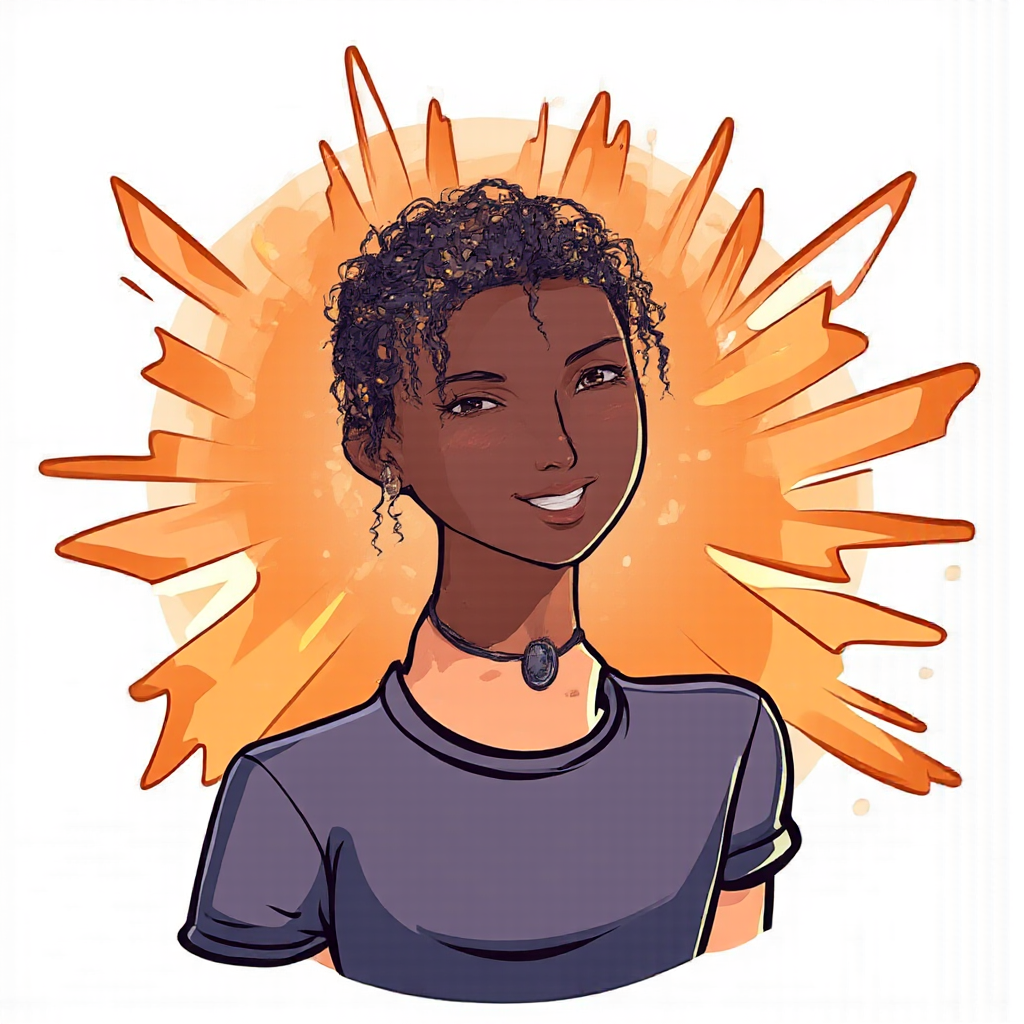

In [7]:
display(Image.open(results[0]))

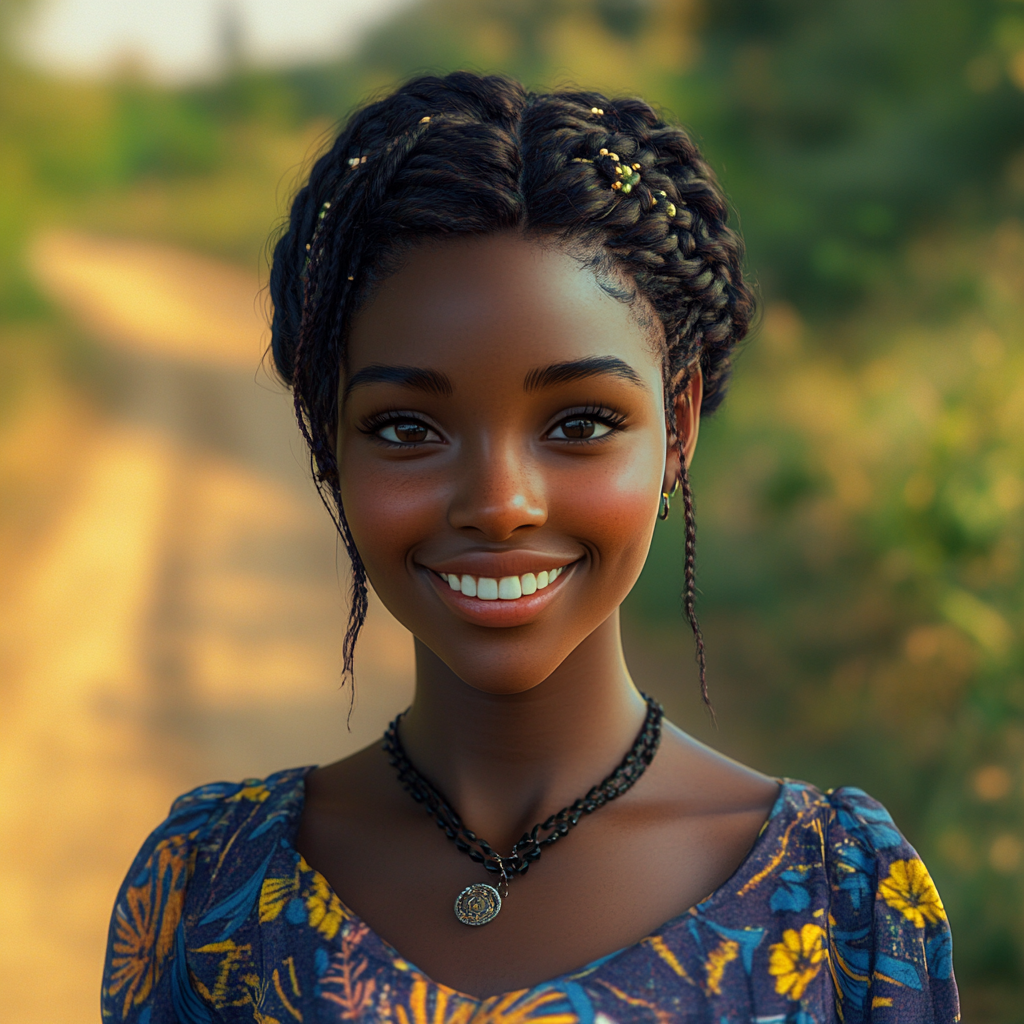

In [8]:
display(Image.open(reference_image))

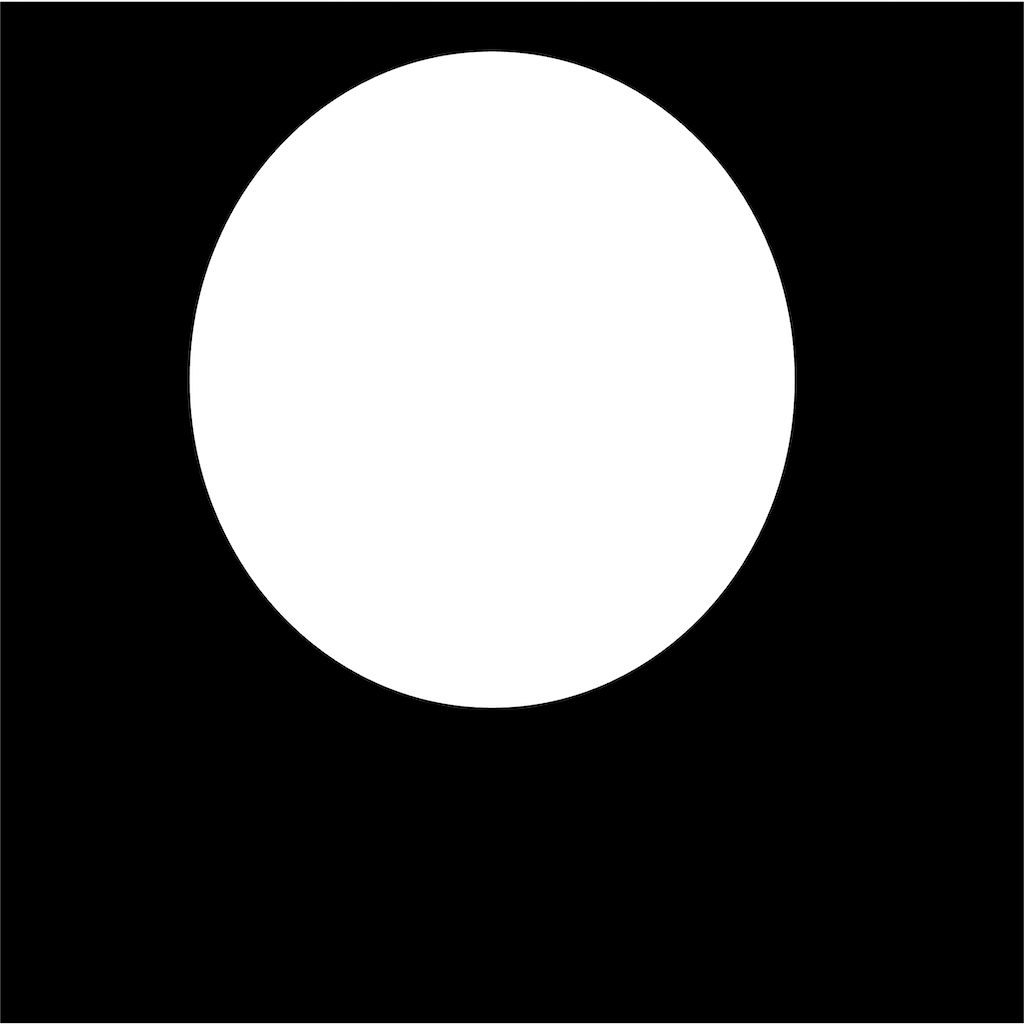

In [5]:
display(Image.open(mask_image))